In [1]:
import numpy as np
import pandas as pd
import preprocessor as p   # tweets preprocessor
import re
import spacy
from contractions import CONTRACTION_MAP
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from  nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import scale
from sklearn.metrics import roc_curve, auc
import random

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import keras

from sklearn import metrics

import itertools 
import collections
from collections import defaultdict
pd.options.display.max_colwidth = 200


import matplotlib.pyplot as pl
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
nlp = spacy.load("en_core_web_md")
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [3]:
##Import dataset 
df = pd.read_csv("/Data Science/DSC/Natural Language Processing.bin/dataset/Tweets.csv")

In [4]:
df.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


# Exploratory Data Analysis 

In [5]:
## check the distribution of sentiment types
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
## generate 'positive' dataset
df_positive = df[df['airline_sentiment'] == 'positive']
df_positive.shape

(2363, 15)

In [7]:
## generate 'neutral' dataset
df_neutral = df[df['airline_sentiment'] == 'neutral']
df_neutral.shape

(3099, 15)

In [8]:
## generate 'negative' dataset
df_negative = df[df['airline_sentiment'] == 'negative']
df_negative.shape

(9178, 15)

In [9]:
## check " negative reason" for 'negative' dataset
df_negative.groupby('negativereason')['negativereason'].count().sort_values(ascending=False)

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [10]:
## check positive review distribution by airlines
df_positive.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
Southwest         570
Delta             544
United            492
American          336
US Airways        269
Virgin America    152
Name: airline, dtype: int64

In [11]:
##  check negative review distribution by airlines
df_negative.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
United            2633
US Airways        2263
American          1960
Southwest         1186
Delta              955
Virgin America     181
Name: airline, dtype: int64

In [12]:
##  check neutral review distribution by airlines
df_neutral.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
Delta             723
United            697
Southwest         664
American          463
US Airways        381
Virgin America    171
Name: airline, dtype: int64

In [13]:
## check missing values 
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [14]:
##  calculate  and view the frequency of each word
import nltk
from nltk.tokenize import word_tokenize

reviews = df.text.str.cat(sep=' ')
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))

frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

20127


['@',
 '.',
 'to',
 'I',
 'the',
 '!',
 '?',
 'a',
 ',',
 'for',
 'you',
 'united',
 'on',
 '#',
 'and',
 'flight',
 'my',
 'USAirways',
 'AmericanAir',
 'is',
 'in',
 'SouthwestAir',
 'JetBlue',
 'of',
 'it',
 "n't",
 ':',
 'me',
 'have',
 'was',
 'that',
 'your',
 'with',
 "'s",
 'at',
 'not',
 'get',
 'do',
 'be',
 'from',
 'this',
 'http',
 'no',
 'but',
 'are',
 'Cancelled',
 '...',
 'we',
 'an',
 ';']

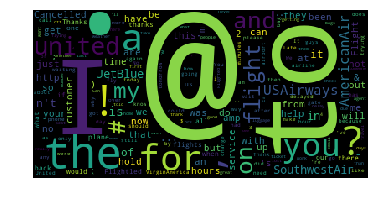

In [17]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Train test split

In [15]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [16]:
df['airline_sentiment'] = df['airline_sentiment'].map({'positive':1,'neutral':0,'negative':-1})

In [18]:
X_train,X_test,y_train,y_test = train_test_split(df['text'],df['airline_sentiment'],test_size=0.33, random_state=53)

# Text Data Preprocessing

## define some functions

In [19]:
## Expand contractions

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [20]:
## Remove special characters

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', ' ', text)
    return text

In [21]:
## Lemmatization

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [22]:
## remove stopwords

def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [25]:
def clean_tweets(df_tmp):
    tempArr = []
    for line in df_tmp:
    #send to tweet_processor
        tmpL = p.clean(line)
        tmpL = expand_contractions(tmpL.lower())
        tmpL = remove_special_characters(tmpL)
        tmpL = lemmatize_text(tmpL)
        #tmpL = remove_stopwords(tmpL)
        #remove puctuation
        #tmpL = REPLACE_NO_SPACE.sub("", tmpL) 
        #tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
        tempArr.append(tmpL)
    return tempArr

In [26]:
# clean both train/test dataset and the entire dataset 
X_train_cleaned = clean_tweets(X_train)
X_test_cleaned = clean_tweets(X_test)
X_cleaned = clean_tweets(df['text'])

In [27]:
df['text'][0:5]

0                                                                                               @VirginAmerica What @dhepburn said.
1                                                          @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                           @VirginAmerica I didn't today... Must mean I need to take another trip!
3    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                           @VirginAmerica and it's a really big bad thing about it
Name: text, dtype: object

In [28]:
X_cleaned[0:5]

['what say',
 'plus you have add commercial to the experience     tacky',
 'i do not today     must mean i need to take another trip',
 'it be really aggressive to blast obnoxious   entertainment   in your guest face   amp   they have little recourse',
 'and it be a really big bad thing about it']

## CountVectorization

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
count_train= count_vectorizer.fit_transform(X_train_cleaned)
count_test= count_vectorizer.transform(X_test_cleaned)

In [31]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df.head()

,00,000,000419,00a,00am,00p,00pm,0200,03,04,...,zagg,zambia,zcc82u,zero,zig,zip,zipper,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TFIDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train_cleaned)
tfidf_test = tfidf_vectorizer.transform(X_test_cleaned)

In [33]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

,00,000,000419,00a,00am,00p,00pm,0200,03,04,...,zagg,zambia,zcc82u,zero,zig,zip,zipper,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#   Model Building

## Naive Bayes using CountVectorization

In [34]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train,y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test,pred)

0.7493791390728477

In [35]:
metrics.confusion_matrix(y_test,pred,labels=nb_classifier.classes_)

array([[2827,  115,   62],
       [ 575,  374,   78],
       [ 317,   64,  420]])

In [36]:
labels = nb_classifier.classes_
conf_df = pd.DataFrame(metrics.confusion_matrix(y_test, pred), columns=labels, index=labels)
conf_df.index.name = 'True labels'

In [32]:
conf_df

,negative,neutral,positive
True labels,,,
negative,2824,118,62
neutral,572,376,79
positive,316,65,420


## Cross validation

In [38]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = MultinomialNB()
print(cross_val_score(clf, count_train, y_train, cv=k_fold, n_jobs=1))
print(cross_val_score(clf, count_train, y_train, cv=k_fold, n_jobs=1).mean())

[0.75331295 0.74923547 0.74311927 0.74719674 0.74821611 0.73700306
 0.74923547 0.73496432 0.75408163 0.7244898 ]
0.7440854812873162


## SVC using using CountVectorization

In [39]:
svc_classifier = SVC()
svc_classifier.fit(count_train,y_train)
pred = svc_classifier.predict(count_test)
metrics.accuracy_score(y_test,pred)

0.7704884105960265

## Cross validation

In [40]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
print(cross_val_score(clf, count_train, y_train, cv=k_fold, n_jobs=1))

print(cross_val_score(clf, count_train, y_train, cv=k_fold, n_jobs=1).mean())

[0.75535168 0.76554536 0.77166157 0.75840979 0.75331295 0.745158
 0.78389399 0.74413863 0.77346939 0.73061224]
0.7581553600033286


## Naive Bayes using Tfidf

In [41]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train,y_train)
pred = nb_classifier.predict(tfidf_test)
metrics.accuracy_score(y_test,pred)

0.6827400662251656

## Cross validation

In [43]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = MultinomialNB()
print(cross_val_score(clf, tfidf_train, y_train, cv=k_fold, n_jobs=1))
print(cross_val_score(clf, tfidf_train, y_train, cv=k_fold, n_jobs=1).mean())

[0.70642202 0.70642202 0.67482161 0.67787971 0.69520897 0.66768603
 0.69520897 0.68093782 0.69897959 0.66428571]
0.6867852462085751


## SVC using Tfidf

In [44]:
svc_classifier = SVC()
svc_classifier.fit(tfidf_train,y_train)
pred = svc_classifier.predict(tfidf_test)
metrics.accuracy_score(y_test,pred)

0.7651076158940397

## cross validation

In [45]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
print(cross_val_score(clf, tfidf_train, y_train, cv=k_fold, n_jobs=1))
print(cross_val_score(clf, tfidf_train, y_train, cv=k_fold, n_jobs=1).mean())

[0.76146789 0.75535168 0.75637105 0.75229358 0.75739042 0.72986748
 0.7675841  0.73190622 0.76122449 0.72755102]
0.7501007926106221


# Gensim word2vec
## training model from scratch

In [46]:
# import packages and dataset 

import gensim
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
import preprocessor as p

df = pd.read_csv("/Data Science/DSC/Natural Language Processing.bin/dataset/Tweets.csv")
df['airline_sentiment'] = df['airline_sentiment'].map({'positive':1,'neutral':0,'negative':-1})

In [47]:
## check the first 10 rows 
df['text'].iloc[0:10]

0                                                                                                         @VirginAmerica What @dhepburn said.
1                                                                    @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                     @VirginAmerica I didn't today... Must mean I need to take another trip!
3              @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                     @VirginAmerica and it's a really big bad thing about it
5    @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6                                                             @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7     

In [48]:
## define fuction for data cleaning
def labelize_reviews(tweets):
    for i, v in enumerate(tweets):
        v_clean = p.clean(v).lower()   # imported tweets processor
        v_clean_1 = expand_contractions(v_clean)  # expand_contraction defined above
        v_clean_2 = remove_stopwords(v_clean_1)
        yield gensim.utils.simple_preprocess(v_clean_2, min_len=3 ,max_len=50)

In [49]:
## clean the text 
df_tagged = list(labelize_reviews(df['text']))

In [50]:
## check cleaned data
df_tagged[0:10]

[['said'],
 ['plus', 'added', 'commercials', 'experience', 'tacky'],
 ['today', 'mean', 'need', 'trip'],
 ['aggressive',
  'blast',
  'obnoxious',
  'entertainment',
  'guests',
  'faces',
  'amp',
  'little',
  'recourse'],
 ['big', 'bad', 'thing'],
 ['seriously', 'pay', 'flight', 'seats', 'playing', 'bad', 'thing', 'flying'],
 ['yes', 'nearly', 'time', 'fly', 'ear', 'worm', 'wont', 'away'],
 ['missed', 'prime', 'opportunity', 'men', 'hats', 'parody', 'there'],
 ['well', 'notbut'],
 ['amazing', 'arrived', 'hour', 'early', 'good']]

In [51]:
## define the parameters for word2vec model traning 
import multiprocessing
num_features = 100
min_word_count = 5
num_workers = multiprocessing.cpu_count()
context_size = 5
seed = 1

In [52]:
## define gensim word2vec model 
import gensim
word2vec_model = gensim.models.Word2Vec(
    sg=0,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)

In [53]:
# check the size of vocabulary
word2vec_model.build_vocab(sentences=df_tagged)
print("The vocabulary is built")
print("Word2Vec vocabulary length: ", len(word2vec_model.wv.vocab))

The vocabulary is built
Word2Vec vocabulary length:  2631


In [54]:
## train gensim model using cleaned data 
word2vec_model.train(sentences=df_tagged,total_examples=word2vec_model.corpus_count,epochs=500)
print("Training finished") 

Training finished


In [55]:
## define the function to caculate the average value for each document in the corpus 

def build_word_vector(text, size=num_features):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += word2vec_model[word]
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [56]:
## create the matriix of word vector for the entire corpus 
df_vecs = np.concatenate([build_word_vector(z) for z in df_tagged])

In [57]:
## train test split 
X_vec_train,X_vec_test,y_train,y_test = train_test_split(df_vecs,df['airline_sentiment'],test_size=0.33, random_state=53)

In [58]:
## using Logistis Regression 
train_vecs = scale(X_vec_train)
test_vecs = scale(X_vec_test)
classifier = LogisticRegression()
classifier.fit(train_vecs, y_train)
print(classifier.score(test_vecs, y_test))

0.7433774834437086


In [59]:
## using SVC model 
svc_classifier = SVC()
svc_classifier.fit(train_vecs, y_train)

print(svc_classifier.score(test_vecs, y_test))

0.7630380794701986


## Using pre-trianed word2vec model 

In [60]:
## import pre-trained Google News model with 300 dimensions for word vector
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gn_path = 'GoogleNews-vectors-negative300.bin'
gn_model = KeyedVectors.load_word2vec_format(gn_path, binary=True)

In [61]:
## define the function to caculate the average value for each document in the corpus 
def build_word_vector_1(text, size=300):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += gn_model[word]
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [62]:
## ## create the matriix of word vector for the entire corpus 
df_vecs = np.concatenate([build_word_vector_1(z) for z in df_tagged])

In [63]:
## train test split
X_vec_train,X_vec_test,y_train,y_test = train_test_split(df_vecs,df['airline_sentiment'],test_size=0.33, random_state=53)

In [64]:
#train_vecs = scale(X_vec_train)
#test_vecs = scale(X_vec_test)
classifier = LogisticRegression()
classifier.fit(X_vec_train, y_train)

print(classifier.score(X_vec_test, y_test))

0.7659354304635762


In [65]:
## cross validaiton using SVC
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.78415301 0.7807377  0.77595628 0.7602459  0.78825137 0.79781421
 0.79508197 0.76912568 0.78756831 0.78415301]
0.7823087431693989


In [66]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
## cross validation using decision tree

from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = DecisionTreeClassifier()
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.61270492 0.61680328 0.61065574 0.59153005 0.61885246 0.62090164
 0.6181694  0.62431694 0.6181694  0.64754098]
0.619535519125683


In [68]:
## cross validation using Logistic regression 
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = LogisticRegression()
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.74795082 0.75819672 0.76297814 0.7465847  0.77663934 0.77459016
 0.77459016 0.76502732 0.77117486 0.7602459 ]
0.7637978142076502


In [69]:
## GridSearchCV using logistic regression
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.001, 0.1, 1, 10, 100]}
logit = LogisticRegression()
clf = GridSearchCV(logit, parameters)
clf.fit(df_vecs, df['airline_sentiment'])

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [70]:
clf.best_score_

0.7546448087431694

In [71]:
clf.best_params_

{'C': 0.1}

In [72]:
## GridSearchCV using SVC
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.001, 0.1, 1, 10, 100]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(df_vecs, df['airline_sentiment'])

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [73]:
clf.best_score_

0.773360655737705

In [74]:
clf.best_params_

{'C': 1}

# Deep learning on Keras 

In [164]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [165]:
X_cleaned[0:5]

['what say',
 'plus you have add commercial to the experience     tacky',
 'i do not today     must mean i need to take another trip',
 'it be really aggressive to blast obnoxious   entertainment   in your guest face   amp   they have little recourse',
 'and it be a really big bad thing about it']

In [166]:
df['airline_sentiment'][0:5]

0    0
1    1
2    0
3   -1
4   -1
Name: airline_sentiment, dtype: int64

In [167]:
df_labels = keras.utils.to_categorical(df['airline_sentiment'], num_classes=3)

In [168]:
df_labels[0:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [169]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
sequences = tokenizer.texts_to_sequences(X_cleaned)
sequences[0:5]

[[43, 77],
 [477, 7, 12, 261, 1069, 2, 4, 160, 4538],
 [3, 15, 9, 91, 658, 306, 3, 59, 2, 75, 140, 164],
 [16,
  1,
  127,
  2813,
  2,
  2415,
  3376,
  852,
  14,
  22,
  1672,
  959,
  60,
  48,
  12,
  433,
  2146],
 [11, 16, 1, 6, 127, 375, 83, 252, 76, 16]]

In [170]:
max_len = np.max([len(t) for t in sequences])
print(max_len)

33


In [171]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8651 unique tokens.


In [173]:
padded_docs = pad_sequences(sequences, maxlen=max_len, padding='post')
print(padded_docs.shape)

(14640, 33)


In [109]:
len(X_cleaned)

14640

In [82]:
one_hot_results = tokenizer.texts_to_matrix(X_cleaned, mode='binary')

In [106]:
one_hot_results.shape

(14640, 8652)

In [83]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8651 unique tokens.


In [84]:
len(word_index)

8651

In [110]:
padded_docs = pad_sequences(sequences, maxlen=max_len, padding='post')
print(padded_docs.shape)

(14640, 33)


In [180]:
# define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 64, input_length=max_len))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 33, 64)            553728    
_________________________________________________________________
flatten_17 (Flatten)         (None, 2112)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 6339      
Total params: 560,067
Trainable params: 560,067
Non-trainable params: 0
_________________________________________________________________
None


In [181]:
model.fit(padded_docs, df_labels, epochs=10, batch_size=64,validation_split=0.2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 7s 558us/step - loss: 0.8085 - acc: 0.6573 - val_loss: 0.5525 - val_acc: 0.7944
Epoch 2/10
11712/11712 [==============================] - 5s 429us/step - loss: 0.5407 - acc: 0.7917 - val_loss: 0.4622 - val_acc: 0.8265
Epoch 3/10
11712/11712 [==============================] - 5s 439us/step - loss: 0.4004 - acc: 0.8572 - val_loss: 0.4537 - val_acc: 0.8221
Epoch 4/10
11712/11712 [==============================] - 5s 426us/step - loss: 0.3075 - acc: 0.8948 - val_loss: 0.4580 - val_acc: 0.8241
Epoch 5/10
11712/11712 [==============================] - 5s 429us/step - loss: 0.2348 - acc: 0.9269 - val_loss: 0.4812 - val_acc: 0.8227
Epoch 6/10
11712/11712 [==============================] - 5s 429us/step - loss: 0.1802 - acc: 0.9510 - val_loss: 0.4990 - val_acc: 0.8204
Epoch 7/10
11712/11712 [==============================] - 6s 474us/step - loss: 0.1380 - acc: 0.9676 - val_loss: 0.5206 - v

# Using Pre-Trained GloVe Embedding

In [187]:
import os
glove_dir = '/Data Science/DSC/Natural Language Processing.bin/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [188]:
embedding_dim = 100
max_words = 8652

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [189]:
embedding_matrix.shape

(8652, 100)

In [190]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model_GloVe = Sequential()
model_GloVe.add(Embedding(max_words, 100, input_length=33))
model_GloVe.add(Flatten())
model_GloVe.add(Dense(32, activation='relu'))
model_GloVe.add(Dense(3, activation='softmax'))
model_GloVe.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 33, 100)           865200    
_________________________________________________________________
flatten_19 (Flatten)         (None, 3300)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                105632    
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 99        
Total params: 970,931
Trainable params: 970,931
Non-trainable params: 0
_________________________________________________________________


In [191]:
model_GloVe.layers[0].set_weights([embedding_matrix])
model_GloVe.layers[0].trainable = False

In [192]:
model_GloVe.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model_GloVe.fit(padded_docs, df_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 9s 735us/step - loss: 0.7690 - acc: 0.6855 - val_loss: 0.6191 - val_acc: 0.7544
Epoch 2/10
11712/11712 [==============================] - 7s 580us/step - loss: 0.6178 - acc: 0.7491 - val_loss: 0.5776 - val_acc: 0.7835
Epoch 3/10
11712/11712 [==============================] - 7s 581us/step - loss: 0.5297 - acc: 0.7853 - val_loss: 0.5747 - val_acc: 0.7879
Epoch 4/10
11712/11712 [==============================] - 7s 588us/step - loss: 0.4583 - acc: 0.8128 - val_loss: 0.6023 - val_acc: 0.7760
Epoch 5/10
11712/11712 [==============================] - 7s 591us/step - loss: 0.3887 - acc: 0.8467 - val_loss: 0.6434 - val_acc: 0.7637
Epoch 6/10
11712/11712 [==============================] - 7s 600us/step - loss: 0.3234 - acc: 0.8758 - val_loss: 0.7023 - val_acc: 0.7814
Epoch 7/10
11712/11712 [==============================] - 7s 593us/step - loss: 0.2661 - acc: 0.9021 - val_loss: 0.8277 - v

## RNN

In [194]:
from keras.layers import Embedding, SimpleRNN

In [195]:
from keras.layers import Dense
model_RNN = Sequential() 
model_RNN.add(Embedding(max_words, 32)) 
model_RNN.add(SimpleRNN(32)) 
model_RNN.add(Dense(3, activation='softmax'))
model_RNN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc']) 
history = model_RNN.fit(padded_docs, df_labels,epochs=10, batch_size=128, validation_split=0.2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 7s 582us/step - loss: 0.7146 - acc: 0.8435 - val_loss: 0.8113 - val_acc: 0.7247
Epoch 2/10
11712/11712 [==============================] - 3s 242us/step - loss: 0.6197 - acc: 0.8411 - val_loss: 0.7498 - val_acc: 0.7288
Epoch 3/10
11712/11712 [==============================] - 3s 257us/step - loss: 0.5555 - acc: 0.8267 - val_loss: 0.7056 - val_acc: 0.7329
Epoch 4/10
11712/11712 [==============================] - 3s 242us/step - loss: 0.5047 - acc: 0.8253 - val_loss: 0.6785 - val_acc: 0.7346
Epoch 5/10
11712/11712 [==============================] - 3s 268us/step - loss: 0.4654 - acc: 0.8260 - val_loss: 0.6687 - val_acc: 0.7309
Epoch 6/10
11712/11712 [==============================] - 3s 288us/step - loss: 0.4350 - acc: 0.8260 - val_loss: 0.6629 - val_acc: 0.7333
Epoch 7/10
11712/11712 [==============================] - 4s 309us/step - loss: 0.4102 - acc: 0.8260 - val_loss: 0.6655 - v

## LSTM

In [196]:
from keras.layers import LSTM

In [197]:
model_LSTM = Sequential() 
model_LSTM.add(Embedding(max_words, 32)) 
model_LSTM.add(LSTM(32))
model_LSTM.add(Dense(3, activation='softmax'))
model_LSTM.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])
history = model_LSTM.fit(padded_docs, df_labels,epochs=10, batch_size=128, validation_split=0.2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 31s 3ms/step - loss: 0.8816 - acc: 0.6128 - val_loss: 0.6414 - val_acc: 0.7404
Epoch 2/10
11712/11712 [==============================] - 19s 2ms/step - loss: 0.6765 - acc: 0.6891 - val_loss: 0.5511 - val_acc: 0.7497
Epoch 3/10
11712/11712 [==============================] - 21s 2ms/step - loss: 0.5946 - acc: 0.7375 - val_loss: 0.5839 - val_acc: 0.7507
Epoch 4/10
11712/11712 [==============================] - 21s 2ms/step - loss: 0.5526 - acc: 0.7586 - val_loss: 0.5047 - val_acc: 0.7941
Epoch 5/10
11712/11712 [==============================] - 21s 2ms/step - loss: 0.5134 - acc: 0.7865 - val_loss: 0.5247 - val_acc: 0.7910
Epoch 6/10
11712/11712 [==============================] - 20s 2ms/step - loss: 0.4868 - acc: 0.8050 - val_loss: 0.5032 - val_acc: 0.7923
Epoch 7/10
11712/11712 [==============================] - 21s 2ms/step - loss: 0.4633 - acc: 0.8170 - val_loss: 0.5996 - val_acc: